In [1]:
import yaml
from typing import Text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transliterate import translit
import re

import json

from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_log_error,
    mean_absolute_error,
    mean_squared_error,
)
import joblib
import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from scipy import stats

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Настройки matpotlib
plt.rcParams["figure.figsize"] = 15, 7
sns.set_theme()
sns.set(font_scale=1.2)
sns.set_palette("viridis")

In [3]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun, log=False):
    """
    Проверка на overfitting для регрессии
    """
    if log:
        y_pred_train = np.exp(model.predict(X_train))
        y_pred_test = np.exp(model.predict(X_test))
    else:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)
    print(f"{metric_fun.__name__} train: %.3f" % value_train)
    print(f"{metric_fun.__name__} test: %.3f" % value_test)
    print(f"delta = {(abs(value_train - value_test)/value_test*100):.1f} %")

# Описание задачи



Целью проекта является прогнозирование цены за один квадратный метр.<br>
<br>
    Для проекта я выбрал квартиры на сайте ЦИАН. Параметры по которым я выбирал квартиры: в г. Москва, до 5 комнат включительно, для проживания. по 100 квартир на каждую станцию метро из 150 выбранных станций.<br>
<br>
<b>Наименование признаков -</b> <br>
- Название - Название объявления<br>
- Адрес - Адрес квартиры<br>
- Метро - Ближайшая станция метро<br>
- Время до метро - Время до ближайшей станции метро (мин)<br>
- Цена - Цена за квартиру (руб)<br>
- <b>Цена за квадрат - Цена за квадратный метр (руб) (Целевой признак)</b><br>
- Общая площадь - Общая площадь (кв. метры)<br>
- Жилая площадь - Жилая площадь (кв. метры)<br>
- Площадь кухни - Площадь кухни (кв. метры)<br>
- Этаж - Номер этажа из всех этажей дома <br>
- Год постройки - Год постройки дома<br>
- Тип жилья - Вторичка или новостройка <br>
- Высота потолков - Высота потолков (метры) <br>
- Санузел - Количество и тип санузлов<br>
- Вид из окон - Вид из окон<br>
- Ремонт - Тип римонта<br>
- Строительная серия - Строительная серия<br>
- Мусоропровод - Наличие мусоропровода <br>
- Количество лифтов - количество лифтов в доме<br>
- Тип дома - Тип дома<br>
- Тип перекрытий - Тип перекрытий<br>
- Парковка - Вид парковки<br>
- Подъезды - Количество подъездов<br>
- Отопление - Тип отопления<br>
- Аварийность - Аварийность<br>
- Газоснабжение - Наличие газоснабжения<br>
- Балкон/лоджия - Количество и тип балкона/лоджии<br>
- Год сдачи - Год сдачи квартир в доме<br>
- Дом - Сдан или нет<br>
- Отделка - Тип отделки <br>
- Кол-во комнат - количество комнат в квартире.<br>
- Широта метро, долгота метро - координаты метро <br>
- Широта дома, долго дома - координаты дома <br>
- Расстояние до метро, расстояние до центра - Расстояния до ближайшего метро и центра Москвы соответсвенно.<br>
- Округ - Округ Москвы в котором находится квартира.

In [4]:
config_path = "../config/params.yml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


preproc = config["preprocessing"]
training = config["train"]

In [5]:
    with open(config_path, encoding="utf-8") as file:
        config = yaml.load(file, Loader=yaml.FullLoader)


preproc = config["preprocessing"]
training = config["train"]

# Разведочный анализ

In [6]:
def get_dataset(dataset_path: Text) -> pd.DataFrame:
    """
    Получение данных по заданному пути
    :param dataset_path: путь до данных
    :return: датасет
    """
    return pd.read_csv(dataset_path)

In [7]:
df = get_dataset(preproc["cian_full_path"])

In [8]:
df.head()

Адрес        Метро  \
0      Москва, ЦАО, р-н Тверской, ул. Петровка, 20/1      Трубная   
1      Москва, ЦАО, р-н Тверской, Тверская ул., 12С7   Пушкинская   
2      Москва, ЦАО, р-н Тверской, ул. Охотный Ряд, 2  Охотный ряд   
3      Москва, ЦАО, р-н Тверской, ул. Охотный Ряд, 2  Охотный ряд   
4  Москва, ЦАО, р-н Тверской, ул. Большая Дмитров...  Театральная   

   Время до метро         Цена  Цена за квадрат  Общая площадь  Жилая площадь  \
0               5   82000000.0         583215.0          140.6         81.600   
1               3   75000000.0         375000.0          200.0        120.000   
2               2  454889566.0        2188021.0          207.9        122.661   
3               2  508714883.0        2486388.0          204.6        120.714   
4               5  450000000.0        1700680.0          264.6        156.114   

   Площадь кухни  Этаж  Год постройки  ...     Отделка  Этажность здания  \
0         15.600     5           1917  ...  Неизвестно                 5   
1         20.000     6           1917  ...  Неизвестно                 6   
2         35.343     5           2015  ...  Неизвестно                15   
3         34.782     6           2015  ...  Неизвестно                15   
4         30.000     7           2024  ...  Неизвестно                 7   

   Кол-во комнат широта метро долгота метро широта дома  долгота дома  \
0              5    55.767833     37.622028   55.764222     37.617321   
1              5    55.765752     37.603900   55.763908     37.608742   
2              4    55.756969     37.615524   55.757131     37.617114   
3              4    55.756969     37.615524   55.757131     37.617114   
4              5    55.757967     37.619001   55.760849     37.614743   

  Расстояние до центра Расстояние до метро Округ  
0             1.205890            0.498928   ЦАО  
1             1.383347            0.366782   ЦАО  
2             0.464192            0.101442   ЦАО  
3             0.464192            0.101442   ЦАО  
4             0.898965            0.417634   ЦАО  

[5 rows x 32 columns]

## Целевой признак

Посмотрим на распределение целевого признака.

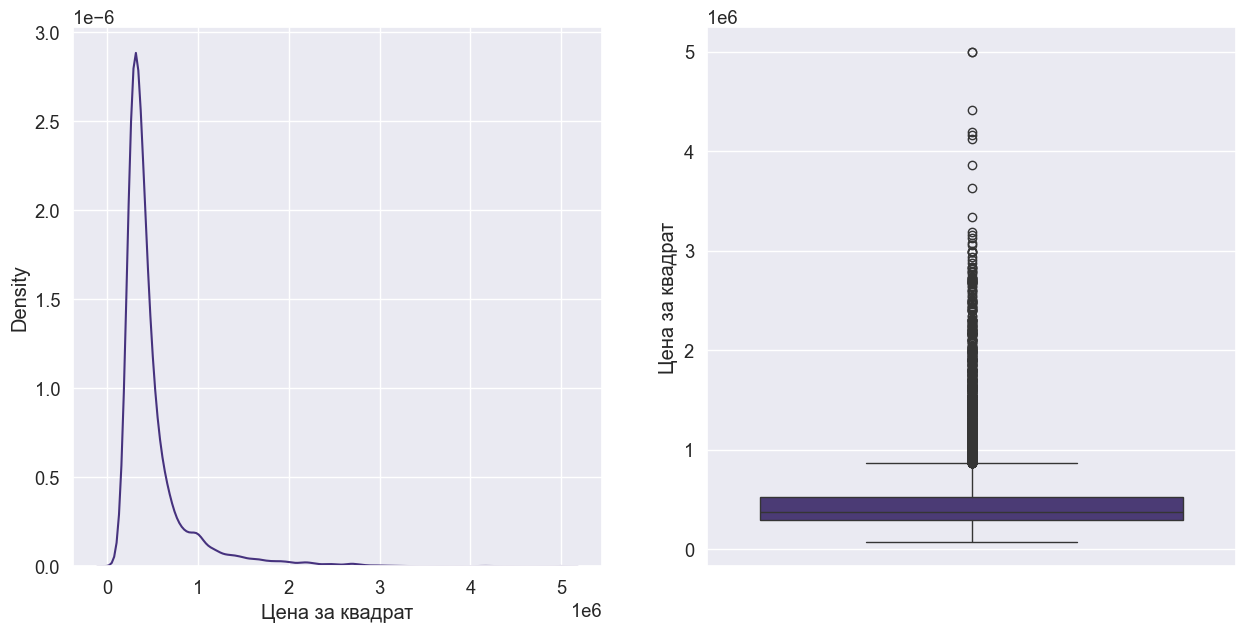

In [9]:
fig, axes = plt.subplots(1, 2)
sns.kdeplot(df["Цена за квадрат"], ax=axes[0])
sns.boxplot(df["Цена за квадрат"], ax=axes[1])
plt.show()

Распределение ненормальное, попробуем прологарифмировать целевой признак.

In [10]:
df['Цена за квадрат лог'] = np.log(df['Цена за квадрат'])

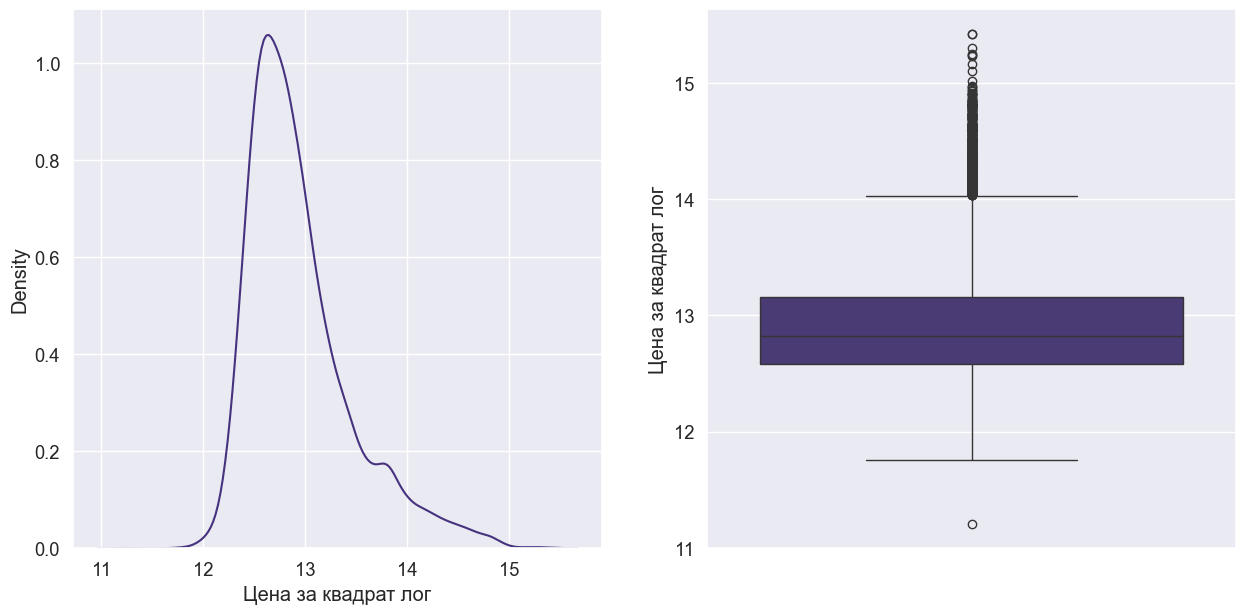

In [11]:
fig, axes = plt.subplots(1, 2)
sns.kdeplot(df["Цена за квадрат лог"], ax=axes[0])
sns.boxplot(df["Цена за квадрат лог"], ax=axes[1])
plt.show()

Прологарифмированный признак более приближен к нормальному. Будем работать с ним. Также есть выбросы, уберем выбросы по нижней границе через IQR.

In [12]:
data = df["Цена за квадрат лог"].copy()
Q1 = data.quantile(q=0.25)
Q3 = data.quantile(q=0.75)
IQR = stats.iqr(data)

In [13]:
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(lower_bound, upper_bound)

11.715293523297433 14.03125576235908


In [14]:
df[(df["Цена за квадрат лог"] < lower_bound)]

Адрес            Метро  \
691  Москва, ЦАО, р-н Мещанский, 2-й Троицкий пер.,...  Цветной бульвар   

     Время до метро       Цена  Цена за квадрат  Общая площадь  Жилая площадь  \
691               9  6400000.0          73648.0           86.9         51.271   

     Площадь кухни  Этаж  Год постройки  ... Этажность здания  Кол-во комнат  \
691           10.0     1           1930  ...                6              2   

     широта метро долгота метро широта дома долгота дома  \
691     55.771758     37.620734   55.776472    37.622378   

     Расстояние до центра Расстояние до метро Округ Цена за квадрат лог  
691              2.548472             0.53489   ЦАО           11.207052  

[1 rows x 33 columns]

In [15]:
df[(df["Цена за квадрат лог"] > upper_bound)]

Адрес          Метро  \
2         Москва, ЦАО, р-н Тверской, ул. Охотный Ряд, 2    Охотный ряд   
3         Москва, ЦАО, р-н Тверской, ул. Охотный Ряд, 2    Охотный ряд   
4     Москва, ЦАО, р-н Тверской, ул. Большая Дмитров...    Театральная   
5     Москва, ЦАО, р-н Тверской, ул. Большая Дмитров...      Чеховская   
7     Москва, ЦАО, р-н Тверской, ул. Большая Дмитров...    Театральная   
...                                                 ...            ...   
9305     Москва, ЦАО, р-н Хамовники, Погодинская ул., 2       Киевская   
9487     Москва, ЦАО, р-н Хамовники, Пожарский пер., 5А  Парк Культуры   
9656  Москва, ЦАО, р-н Хамовники, 1-й Обыденский пер...  Кропоткинская   
9730         Москва, ЦАО, р-н Хамовники, пер. Хилков, 5  Парк Культуры   
9741  Москва, ЦАО, р-н Хамовники, 3-я Фрунзенская ул...     Спортивная   

      Время до метро         Цена  Цена за квадрат  Общая площадь  \
2                  2  454889566.0        2188021.0         207.90   
3                  2  508714883.0        2486388.0         204.60   
4                  5  450000000.0        1700680.0         264.60   
5                  8  184000000.0        1260274.0         146.00   
7                  4  450000000.0        1518219.0         296.40   
...              ...          ...              ...            ...   
9305              14  230000000.0        1377246.0         167.00   
9487              14  320000000.0        1895398.0         168.83   
9656               3  440000000.0        2303665.0         191.00   
9730               5  163000000.0        1442478.0         113.00   
9741               7   84500000.0        1261194.0          67.00   

      Жилая площадь  Площадь кухни  Этаж  Год постройки  ... Этажность здания  \
2           122.661        35.3430     5           2015  ...               15   
3           120.714        34.7820     6           2015  ...               15   
4           156.114        30.0000     7           2024  ...                7   
5            86.140        24.8200     3           2007  ...                6   
7           174.876        50.3880     7           2024  ...                7   
...             ...            ...   ...            ...  ...              ...   
9305         98.530        28.0000     7           2019  ...               13   
9487         91.000        28.7011     2           2004  ...                7   
9656        130.000        22.0000     3           2002  ...                6   
9730         66.670        19.2100     2           2008  ...                6   
9741         27.600        14.3000     3           2006  ...                9   

      Кол-во комнат  широта метро долгота метро широта дома долгота дома  \
2                 4     55.756969     37.615524   55.757131    37.617114   
3                 4     55.756969     37.615524   55.757131    37.617114   
4                 5     55.757967     37.619001   55.760849    37.614743   
5                 3     55.765843     37.608167   55.762080    37.614186   
7                 5     55.757967     37.619001   55.760849    37.614743   
...             ...           ...           ...         ...          ...   
9305              4     55.743588     37.565587   55.735718    37.572351   
9487              4     55.735307     37.592869   55.740416    37.603774   
9656              4     55.745073     37.603487   55.743259    37.602930   
9730              3     55.735307     37.592869   55.738363    37.597046   
9741              2     55.723328     37.564123   55.723318    37.571965   

      Расстояние до центра Расстояние до метро Округ Цена за квадрат лог  
2                 0.464192            0.101442   ЦАО           14.598508  
3                 0.464192            0.101442   ЦАО           14.726342  
4                 0.898965            0.417634   ЦАО           14.346539  
5                 1.037851            0.564167   ЦАО           14.046840  
7                 0.898965            0.417634   ЦАО           14.23304

In [16]:
df_clean = df[df["Цена за квадрат лог"] > lower_bound]

In [17]:
df_clean.reset_index(drop=True, inplace=True)

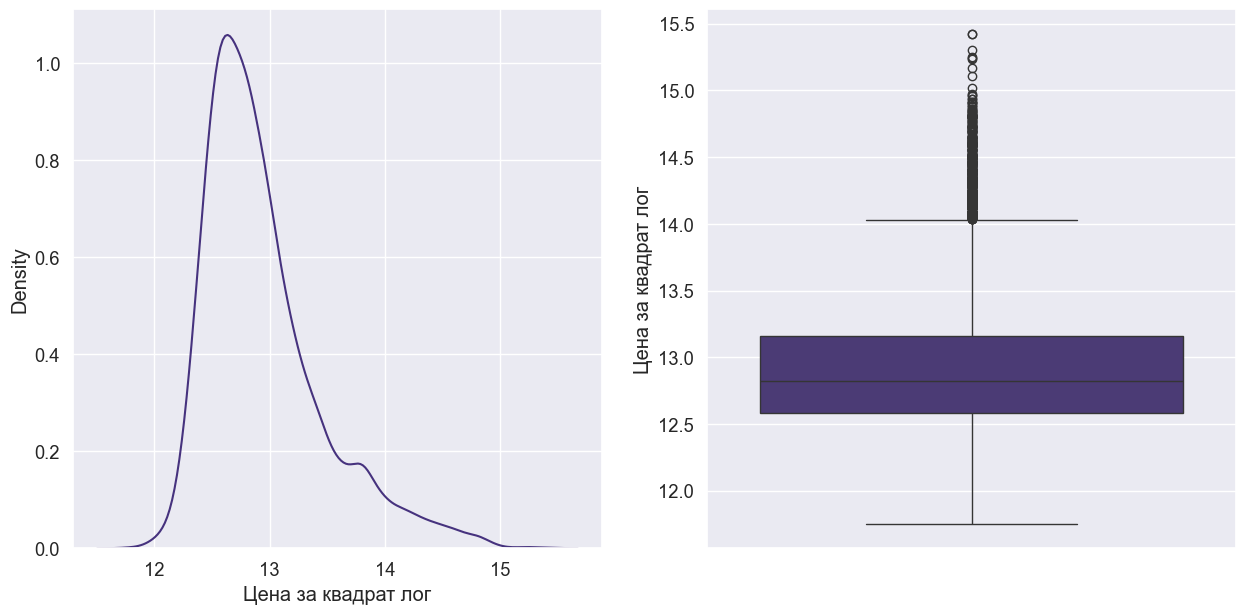

In [18]:
fig, axes = plt.subplots(1, 2)
sns.kdeplot(df_clean["Цена за квадрат лог"], ax=axes[0])
sns.boxplot(df_clean["Цена за квадрат лог"], ax=axes[1])
plt.show()

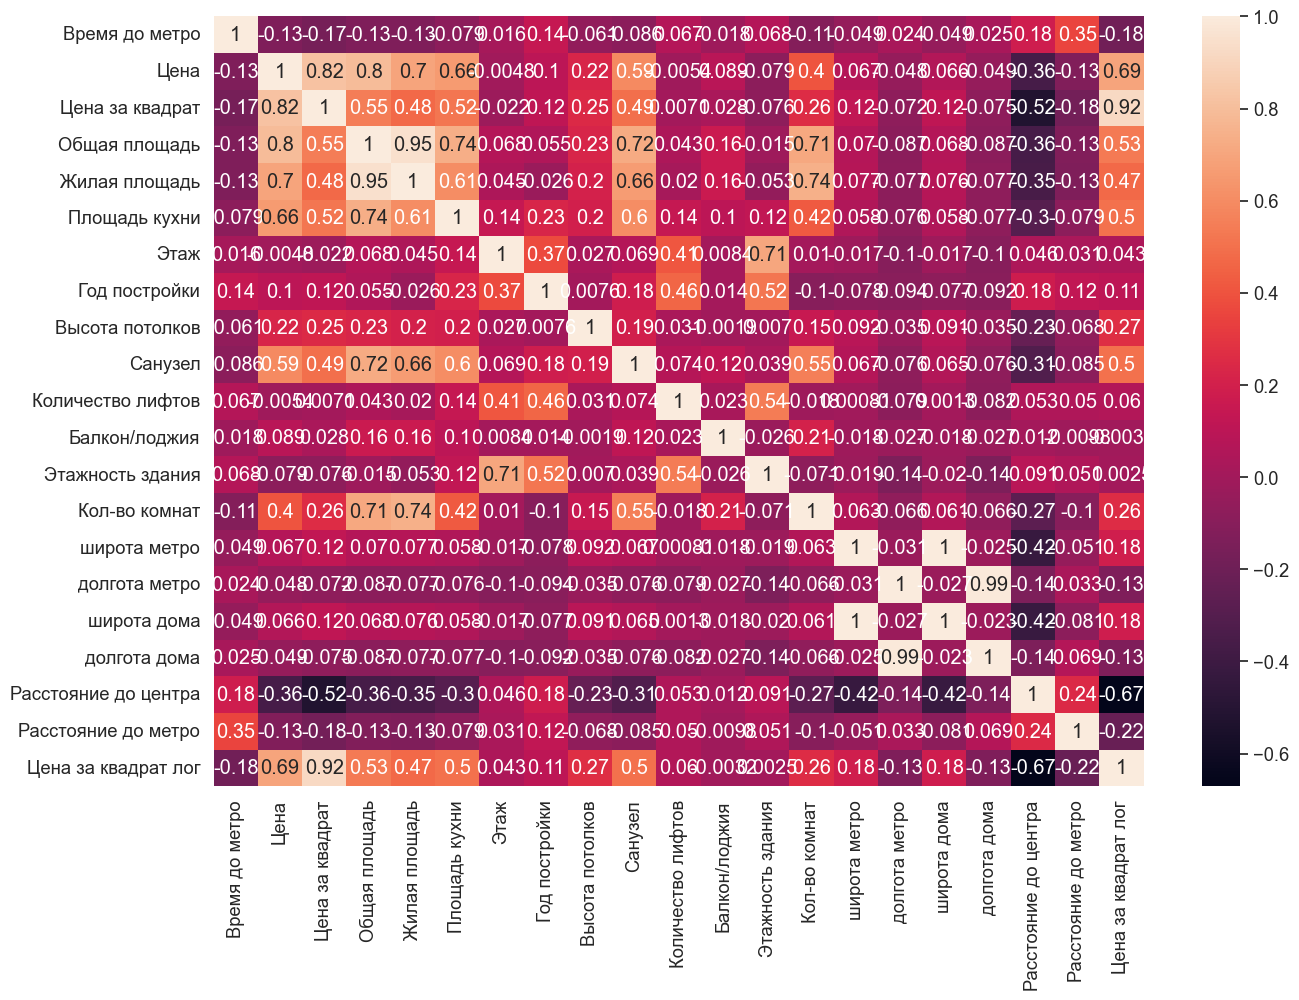

In [19]:
plt.figure(figsize=(15, 10))

sns.heatmap(df_clean.corr(numeric_only=True), annot=True)
plt.show()

**Гипотезы:**

- 1. Между расстоянием до метро и ценой за квадрат есть корреляция. Чем меньше расстояние до метро, тем выше цена за квадрат.
- 2. Между расстоянием до центра Москвы и ценой за квадрат есть корреляция. Чем меньше расстояние до центра Москвы, тем выше цена за квадрат.
- 3. Квартиры на первом и последнем этаже стоят дешевле чем на других этажах.
- 4. Между годом постройки и расстоянием до метро есть корреляция. У новых домов расстояние будет меньше. 
- 5. Между этажностью и количеством лифтов есть корреляция. Чем больше этажность тем больше лифтов.
- 6. Квартиры с более высокими потолками будут дороже.

In [20]:
def check_ttest(a: pd.Series, popmean: float, alt: str):
    t_stat, p_value = stats.ttest_1samp(a=a, popmean=popmean, alternative=alt)
    print("Statistic:", t_stat)
    print("p-value:", p_value)
    if alpha < p_value:
        print("H0 не отвергается")
    else:
        print("H0 отвергается")

In [21]:
def check_corr(a: pd.Series, b: pd.Series):
    correlation, p_value = stats.spearmanr(a, b)
    print("Коэффициент корреляции:", correlation)
    print("p-значение:", p_value)
    if alpha < p_value:
        print('H0 не отвергается')
    else:
        print('H0 отвергается')

In [22]:
alpha = 0.05

## Гипотезы

In [23]:
def pair_plot(data: pd.DataFrame, data_x: str, data_y: str, title: str):
    """
    Отрисовка графика PairPlot
    :param data_y: Признак.
    :param data_x: Признак.
    :param data: Датасет.
    :param title: Название графика.
    """
    sns.pairplot(data[[data_x, data_y]], height=5, palette="viridis")
    plt.title(title, y=2.1, x=-0.1)


def reg_heat_plot(data: pd.DataFrame, data_x: str, data_y: str, title: str):
    """
    Отрисовка regplot вместе с heatplot.
    :param data: Датасет.
    :param data_x: Признак по Х
    :param data_y: Признак по Y
    :param title: Название графика.
    """

    fig, axes = plt.subplots(1,2)
    sns.regplot(x=data[data_x], y=data[data_y], ax=axes[0], marker="o")
    sns.heatmap(data=(data[[data_x, data_y]]).corr(), annot=True, ax=axes[1])
    plt.title(title, x=-0.1, fontsize=20)
    plt.ylabel(data_y, fontsize=18)
    plt.xlabel(data_x, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)



def kde_plot(data_1: pd.Series, title: str, data_2: pd.Series = None, leg: list = None):
    """
    Отрисовка kdeplot.
    :param data_1: Признак из датасета
    :param data_2: Признак из датасета
    :param title: Название графика
    :param leg: Список наименований для легенды
    """
    fig = plt.figure()
    sns.kdeplot(data_1, color="r", common_norm=False, palette="viridis")
    sns.kdeplot(data_2, common_norm=False, palette="viridis")
    plt.title(title, fontsize=20)
    plt.legend(labels=leg)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)



def bar_plot(data: pd.DataFrame, data_x: str, data_y: str, title: str):
    """
    Отрисовка barplot.
    :param data: датасет
    :param data_x: Признак по Х
    :param data_y: Признак по Y
    :param title: Название графика
    """
    fig = plt.figure()
    sns.barplot(data=data, x=data_x, y=data_y, palette="viridis")
    plt.title(title, fontsize=20)
    plt.ylabel(data_y, fontsize=18)
    plt.xlabel(data_x, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)



def box_plot(data: pd.DataFrame, data_x: str, data_y: str, title: str):
    """
    Отрисовка boxplot
    :param data: датасет
    :param data_x: Признак по Х
    :param data_y: Признак по Y
    :param title: Название графика
    """
    fig = plt.figure()
    sns.boxplot(data, y=data_y, x=data_x, orient="h", palette="viridis")
    plt.title(title, fontsize=20)
    plt.ylabel(data_y, fontsize=18)
    plt.xlabel(data_x, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)



### 1 Гипотеза. Чем меньше расстояние до метро, тем выше цена за квадрат.

H0: Между расстоянием до метро и ценой за квадрат нет корреляции.<br>
H1: Между расстоянием до метро и ценой за квадрат есть корреляция.

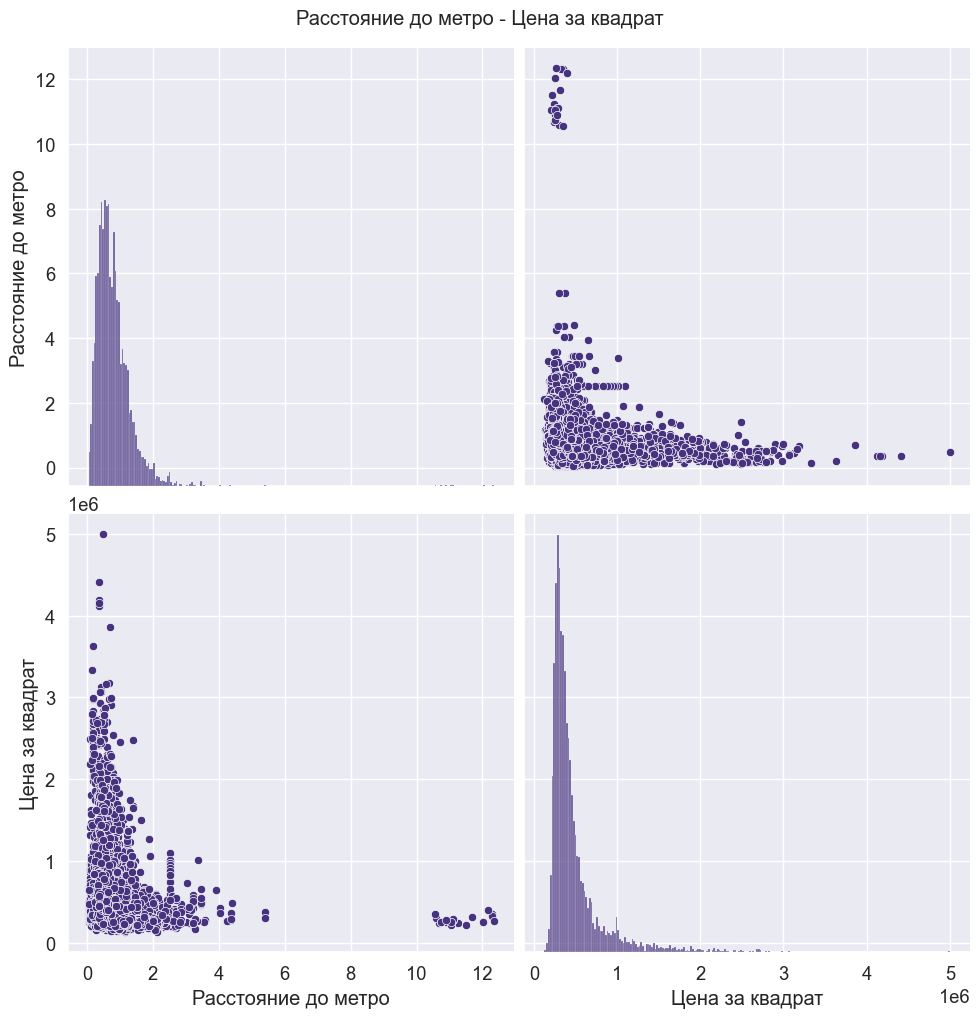

In [24]:
pair_plot(
                data=df_clean,
                data_x="Расстояние до метро",
                data_y="Цена за квадрат",
                title="Расстояние до метро - Цена за квадрат",
            )

<div class="alert alert-block alert-success" > 
<b>Вывод:</b><br>
Между признаками есть корреляция, но совсем небольшая. Зато мы видим, что большинство квартир продаются близко к метро, так как в Москве на данный момент сильно развит метрополитен.
</div>

### 2 Гипотеза. Чем меньше расстояние до центра Москвы, тем выше цена за квадрат.

H0: Между расстоянием до центра Москвы и ценой за квадрат нет корреляции.<br>
H1:Между расстоянием до центра Москвы и ценой за квадрат есть корреляцияя.

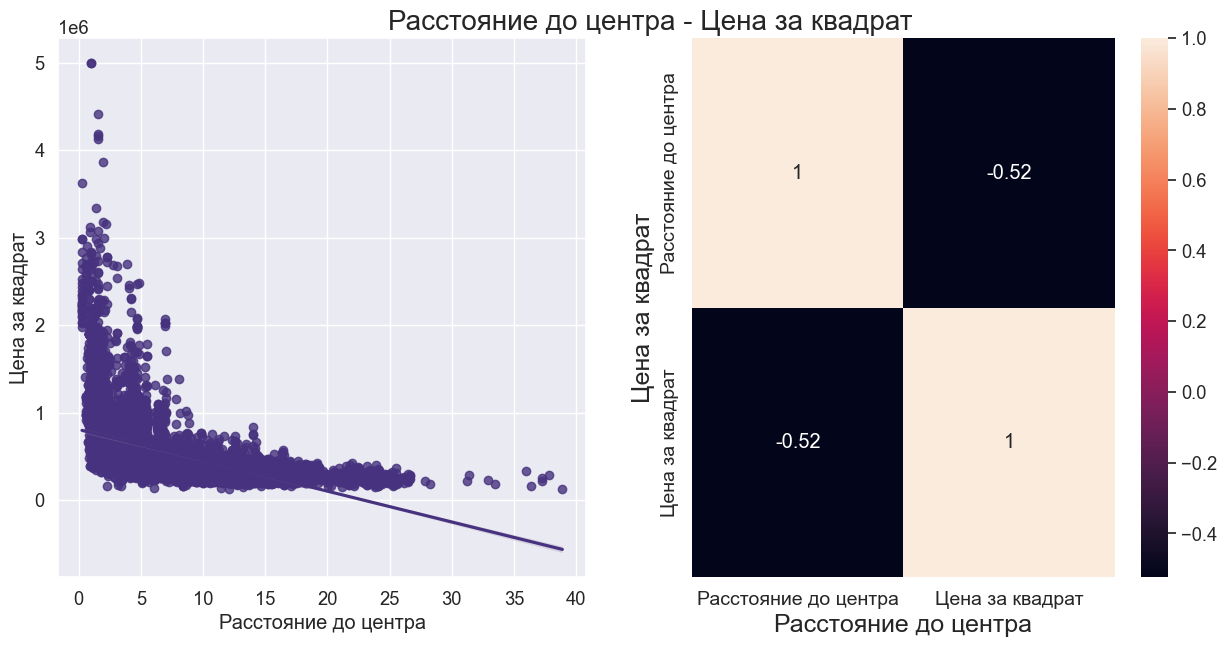

In [25]:
reg_heat_plot(
                data=df_clean,
                data_x="Расстояние до центра",
                data_y="Цена за квадрат",
                title="Расстояние до центра - Цена за квадрат",
            )

<div class="alert alert-block alert-success" > 
<b>Вывод:</b><br>
Между признаками есть достаточно сильная корреляция. Цена за 1 квадратный метр ближе к центру города выше.
</div>

### 3 Гипотеза. Квартиры на первом и последнем этаже стоят дешевле чем на других этажах.

H0: Квартиры на первом и последнем этаже стоят дешевле чем на других этажах.<br>
H1: Квартиры на первом и последнем этаже стоят дороже чем на других этажах.

In [26]:
fl_floor = df_clean[(df_clean['Этаж'] == 1) | (
    df_clean['Этаж'] == df_clean['Этажность здания'])]['Цена за квадрат']

In [27]:
other_floor = df_clean.drop(fl_floor.index)['Цена за квадрат']

In [28]:
type(other_floor)

pandas.core.series.Series

In [29]:
check_ttest(fl_floor, other_floor.mean(), 'greater')

Statistic: -0.46846807102752813
p-value: 0.6802448785681108
H0 не отвергается


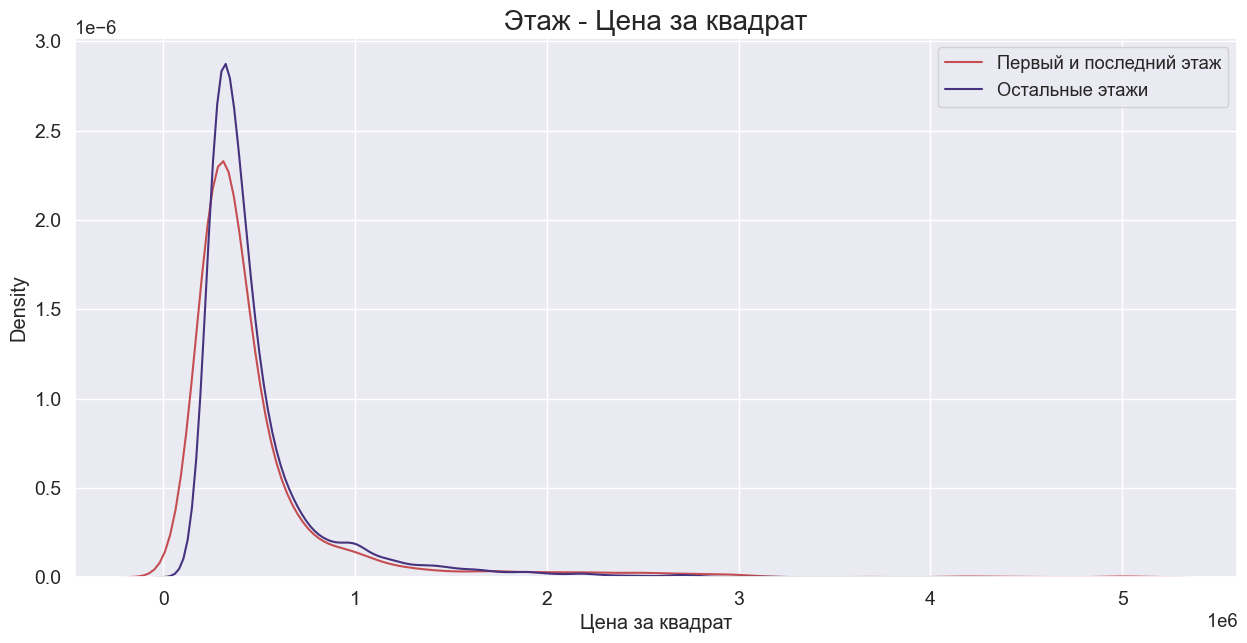

In [30]:
kde_plot(
                data_1=fl_floor,
                data_2=other_floor,
                title="Этаж - Цена за квадрат",
                leg=["Первый и последний этаж", "Остальные этажи"],
            )

<div class="alert alert-block alert-success" > 
<b>Вывод:</b><br>
Гипотеза подтвердилась. Цена за квадрат квартир на первом и последнем этаже ниже чем у остальных. В первом случае из-за подвала и высокого уровня шума с улицы. В втором случае из-за возможных протечек крыши.
</div>

## 4 Гипотеза. Цена за квадрат квартир у которых подземная или многоуровневая парковка выше.

H0: Цена за квадратный метр квартир c подземной или многоуровневой парковкой выше чем у других.<br>
H1: Цена за квадратный метр квартир c подземной или многоуровневой парковкой ниже чем у других.

Statistic: 25.619711868789775
p-value: 1.0
H0 не отвергается


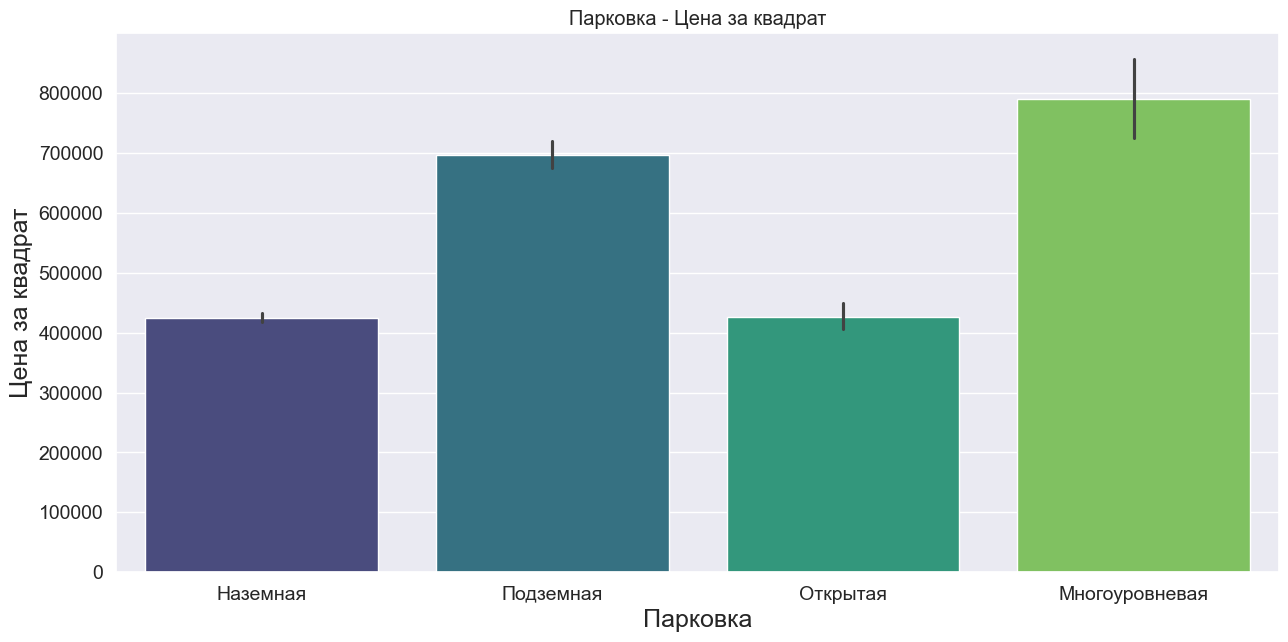

In [31]:
parking = df_clean[(df_clean['Парковка'] == 'Подземная') | (
    df_clean['Парковка'] == 'Многоуровневая')]['Цена за квадрат']
check_ttest(parking, df_clean.drop(parking.index)
            ['Цена за квадрат'].mean(), 'less')

bar_plot(
                data=df_clean,
                data_x="Парковка",
                data_y="Цена за квадрат",
                title="Парковка - Цена за квадрат",
            )

plt.title('Парковка - Цена за квадрат')
plt.show()

<div class="alert alert-block alert-success" > 
<b>Вывод:</b><br>
Гипотеза подтвердилась. Квартиры в домах с подземной или многоуровневой парковкой дороже чем остальные. Связано с тем, что машина в любое время года находится в теплом, закрытом помещении. И нет необходимости зимой тратить время на прогрев машины и очистку от снега в зимнее время.
</div>

## 5 Гипотеза. Цена за квадрат у квартир в монолитно-кирпичных и кирпичных домах выше чем у других.

In [32]:
df_clean['Тип дома'].value_counts()

Тип дома
Монолитный             5346
Кирпичный              2070
Панельный              1581
Монолитно-кирпичный     436
Блочный                 369
Сталинский               14
Старый фонд               1
Name: count, dtype: int64

Statistic: 7.6159957254356465
p-value: 0.9999999999999816
H0 не отвергается


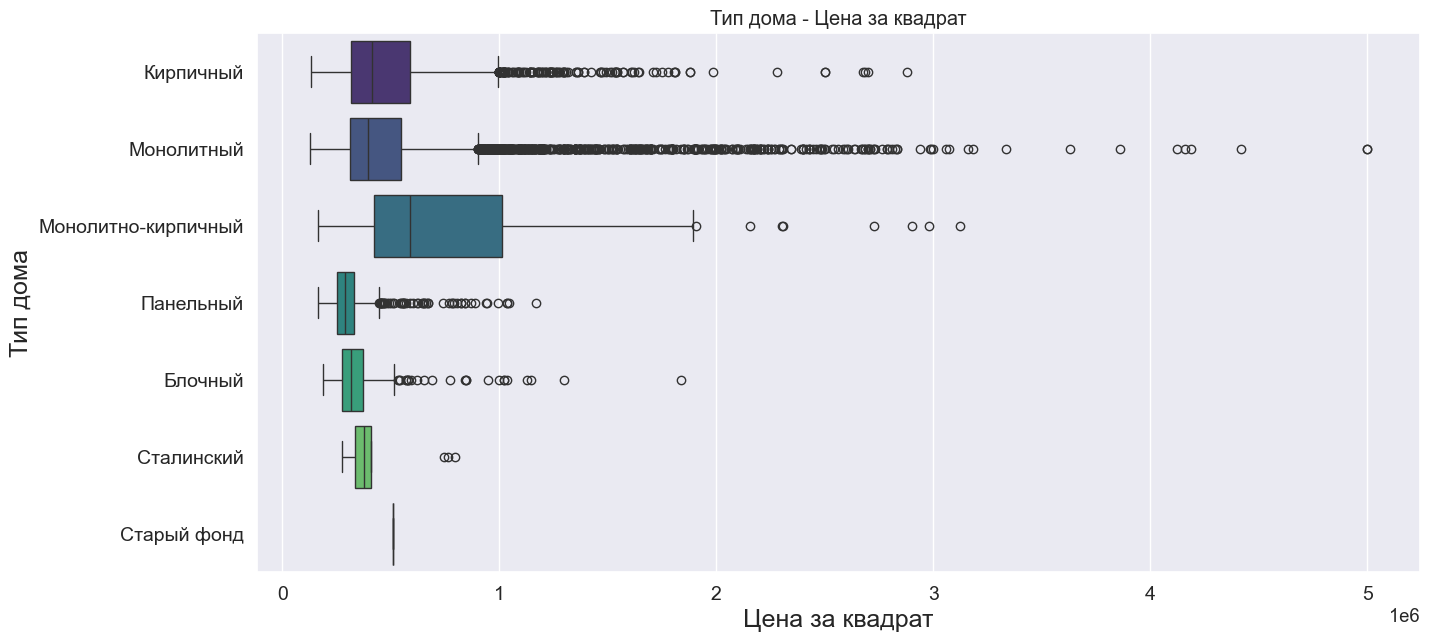

In [33]:
house_type = df_clean[(df_clean['Тип дома'] == 'Монолитно-кирпичный')
                      | (df_clean['Тип дома'] == 'Кирпичный')]['Цена за квадрат']
check_ttest(house_type, df_clean['Цена за квадрат'].mean(), 'less')

box_plot(
                data=df_clean,
                data_x="Цена за квадрат",
                data_y="Тип дома",
                title="Тип дома - Цена за квадрат",
            )

plt.title('Тип дома - Цена за квадрат')
plt.show()

<div class="alert alert-block alert-success" > 
<b>Вывод:</b><br>
Гипотеза подтвердилась. Квартиры в монолитно-кирпичных домах дороже чем в других. У этих домов самый высокий срок эксплуатации, хорошая звуко-изоляция, и эта технология позволяет возводить дома разных форм.
</div>

## Построение признаков

Преобразуем все русские буквы в английские.

In [34]:
def translate(data: pd.DataFrame):
    """
    Перевод названий столбцов на английский язык.
    :param data: датасет
    :return: новый датасет
    """
    cols_translit = [
        translit(x, language_code="ru", reversed=True).replace(" ", "_")
        for x in data.columns
    ]
    data.columns = cols_translit
    data_new = data.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
    return data_new

In [35]:
df_clean = df_clean.drop(columns=training["drop_columns_unique"])

In [36]:
df_clean = translate(df_clean)

Удалим признаки с бесполезной информацией, большим кол-вом уникальных признаков и сильно коррелирующие с целевым признаком.

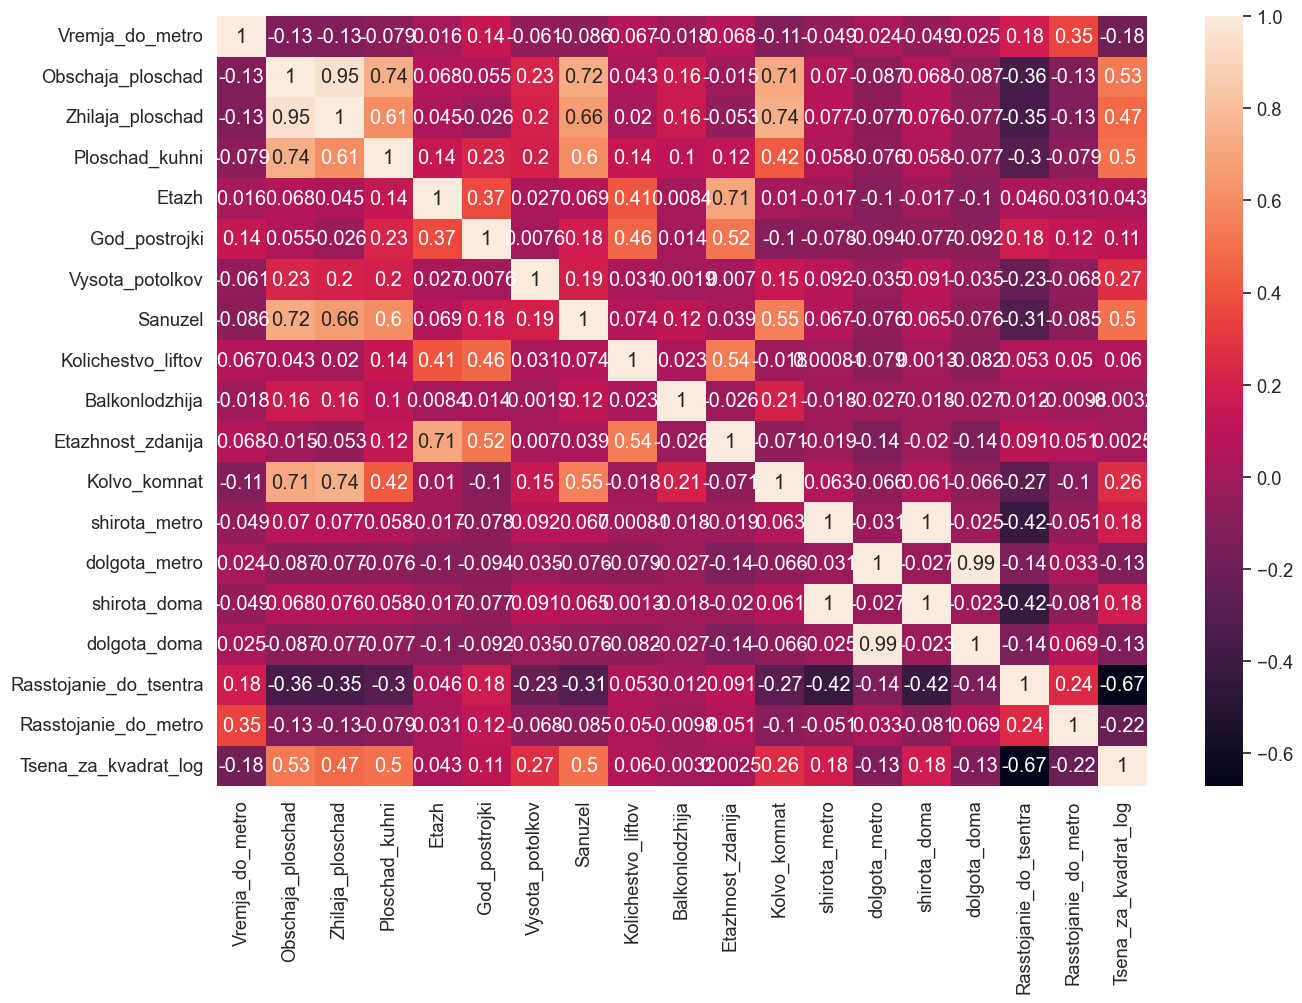

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True)
plt.show()

In [38]:
to_drop = training['drop_columns']


In [39]:
df_clean = df_clean.drop(columns=to_drop)

In [40]:
cat_cols = df_clean.select_dtypes("object").columns
df_clean[cat_cols] = df_clean[cat_cols].astype("category")

In [41]:
df_clean

Vremja_do_metro  Obschaja_ploschad  Zhilaja_ploschad  Ploschad_kuhni  \
0                   5              140.6            81.600          15.600   
1                   3              200.0           120.000          20.000   
2                   2              207.9           122.661          35.343   
3                   2              204.6           120.714          34.782   
4                   5              264.6           156.114          30.000   
...               ...                ...               ...             ...   
9812                6               81.5            41.300          18.700   
9813               20               75.2            52.100           9.000   
9814               10               36.3            21.417           6.171   
9815               14               63.0            46.000           8.000   
9816                7               71.1            48.000          10.000   

      Etazh  God_postrojki   Tip_zhilja  Vysota_potolkov  Sanuzel  \
0         5           1917     Вторичка             3.50        2   
1         6           1917     Вторичка             3.80        4   
2         5           2015     Вторичка             2.87        2   
3         6           2015     Вторичка             2.87        2   
4         7           2024  Новостройка             6.00        4   
...     ...            ...          ...              ...      ...   
9812     40           2024  Новостройка             3.10        2   
9813      2           1975     Вторичка             2.64        1   
9814      3           2020     Вторичка             3.08        1   
9815      1           1969     Вторичка             2.64        1   
9816      5           1969     Вторичка             2.70        1   

          Vid_iz_okon  ... Balkonlodzhija      Otdelka  Etazhnost_zdanija  \
0     На улицу и двор  ...              1   Неизвестно                  5   
1     На улицу и двор  ...              1   Неизвестно                  6   
2     На улицу и двор  ...              1   Неизвестно                 15   
3     На улицу и двор  ...              1   Неизвестно                 15   
4     На улицу и двор  ...              1   Неизвестно                  7   
...               ...  ...            ...          ...                ...   
9812         На улицу  ...              1  Без отделки                 51   
9813          Во двор  ...              3   Неизвестно                 12   
9814          Во двор  ...              1   Неизвестно                 27   
9815         На улицу  ...              1   Неизвестно                  9   
9816          Во двор  ...              1   Неизвестно                 14   

     Kolvo_komnat shirota_doma dolgota_doma Rasstojanie_do_tsentra  \
0               5    55.764222    37.617321               1.205890   
1               5    55.763908    37.608742               1.383347   
2               4    55.757131    37.617114               0.464192   
3               4    55.757131    37.617114               0.464192   
4               5    55.760849    37.614743               0.898965   
...           ...          ...          ...                    ...   
9812            3    55.754861    37.528253               5.827063   
9813            4    55.893662    37.613521              15.601968   
9814            1    55.767484    37.500270               7.737237   
9815            3    55.626167    37.592348              14.301570   
9816            3    55.770355    37.658904               3.022340   

      Rasstojanie_do_metro Okrug  Tsena_za_kvadrat_log  
0                 0.498928   ЦАО             13.276311  
1                 0.366782   ЦАО             12.834681  
2                 0.101442   ЦАО             14.598508  
3                 0.101442   ЦАО             14.726342  
4                 0.417634   ЦАО             14.346539  
...                    ...   ...                   ...  
9812              0.363443   ЦАО             13.028053  
9813              

In [42]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9817 entries, 0 to 9816
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Vremja_do_metro         9817 non-null   int64   
 1   Obschaja_ploschad       9817 non-null   float64 
 2   Zhilaja_ploschad        9817 non-null   float64 
 3   Ploschad_kuhni          9817 non-null   float64 
 4   Etazh                   9817 non-null   int64   
 5   God_postrojki           9817 non-null   int64   
 6   Tip_zhilja              9817 non-null   category
 7   Vysota_potolkov         9817 non-null   float64 
 8   Sanuzel                 9817 non-null   int64   
 9   Vid_iz_okon             9817 non-null   category
 10  Remont                  9817 non-null   category
 11  Musoroprovod            9817 non-null   category
 12  Kolichestvo_liftov      9817 non-null   int64   
 13  Tip_doma                9817 non-null   category
 14  Tip_perekrytij          

In [43]:
def save_unique_train_data(
        data: pd.DataFrame, drop_columns: list, target_column: str, unique_values_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(
        columns=drop_columns + [target_column], axis=1, errors="ignore"
    )
    # создаем словарь с уникальными значениями для вывода в UI
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [44]:
# проверка dataset на совпадение с признаками из train
    # либо сохранение уникальных данных с признаками из train
save_unique_train_data(
data=df_clean,
drop_columns=training["drop_columns"],
target_column=training["target_column"],
unique_values_path=training["unique_values_path"],
)

In [45]:
df_clean

Vremja_do_metro  Obschaja_ploschad  Zhilaja_ploschad  Ploschad_kuhni  \
0                   5              140.6            81.600          15.600   
1                   3              200.0           120.000          20.000   
2                   2              207.9           122.661          35.343   
3                   2              204.6           120.714          34.782   
4                   5              264.6           156.114          30.000   
...               ...                ...               ...             ...   
9812                6               81.5            41.300          18.700   
9813               20               75.2            52.100           9.000   
9814               10               36.3            21.417           6.171   
9815               14               63.0            46.000           8.000   
9816                7               71.1            48.000          10.000   

      Etazh  God_postrojki   Tip_zhilja  Vysota_potolkov  Sanuzel  \
0         5           1917     Вторичка             3.50        2   
1         6           1917     Вторичка             3.80        4   
2         5           2015     Вторичка             2.87        2   
3         6           2015     Вторичка             2.87        2   
4         7           2024  Новостройка             6.00        4   
...     ...            ...          ...              ...      ...   
9812     40           2024  Новостройка             3.10        2   
9813      2           1975     Вторичка             2.64        1   
9814      3           2020     Вторичка             3.08        1   
9815      1           1969     Вторичка             2.64        1   
9816      5           1969     Вторичка             2.70        1   

          Vid_iz_okon  ... Balkonlodzhija      Otdelka  Etazhnost_zdanija  \
0     На улицу и двор  ...              1   Неизвестно                  5   
1     На улицу и двор  ...              1   Неизвестно                  6   
2     На улицу и двор  ...              1   Неизвестно                 15   
3     На улицу и двор  ...              1   Неизвестно                 15   
4     На улицу и двор  ...              1   Неизвестно                  7   
...               ...  ...            ...          ...                ...   
9812         На улицу  ...              1  Без отделки                 51   
9813          Во двор  ...              3   Неизвестно                 12   
9814          Во двор  ...              1   Неизвестно                 27   
9815         На улицу  ...              1   Неизвестно                  9   
9816          Во двор  ...              1   Неизвестно                 14   

     Kolvo_komnat shirota_doma dolgota_doma Rasstojanie_do_tsentra  \
0               5    55.764222    37.617321               1.205890   
1               5    55.763908    37.608742               1.383347   
2               4    55.757131    37.617114               0.464192   
3               4    55.757131    37.617114               0.464192   
4               5    55.760849    37.614743               0.898965   
...           ...          ...          ...                    ...   
9812            3    55.754861    37.528253               5.827063   
9813            4    55.893662    37.613521              15.601968   
9814            1    55.767484    37.500270               7.737237   
9815            3    55.626167    37.592348              14.301570   
9816            3    55.770355    37.658904               3.022340   

      Rasstojanie_do_metro Okrug  Tsena_za_kvadrat_log  
0                 0.498928   ЦАО             13.276311  
1                 0.366782   ЦАО             12.834681  
2                 0.101442   ЦАО             14.598508  
3                 0.101442   ЦАО             14.726342  
4                 0.417634   ЦАО             14.346539  
...                    ...   ...                   ...  
9812              0.363443   ЦАО             13.028053  
9813              

# Обучение

## BaseLine

In [46]:
X = df_clean.drop(training['target_column'], axis=1)
y = df_clean[training['target_column']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=preproc['test_size'], shuffle=True, random_state=preproc['random_state']
)

X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=preproc['test_size_val'], shuffle=True, random_state=preproc['random_state']
)

y_test_exp = np.exp(y_test)
y_val_exp = np.exp(y_val)

In [48]:
clf = LGBMRegressor(random_state=preproc['random_state'], objective="rmse")
eval_set = [(X_val, y_val_exp)]

clf.fit(
    X_train_,
    y_train_,
    eval_set=eval_set,
    eval_metric="rmse",
    verbose=False,
    early_stopping_rounds=100,
)


LGBMRegressor(objective='rmse', random_state=26)

In [49]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def create_dict_metrics(
        y_test: pd.Series, y_pred: pd.Series, x_test: pd.DataFrame) -> dict:
    """
    Получение словаря с метриками для задачи регрессии и запись в словарь
    :param x_test: тестовые данные
    :param y_test: реальные данные
    :param y_pred: предсказанные значения
    :return: словарь с метриками
    """
    dict_metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 3),
        "MSE": round(mean_squared_error(y_test, y_pred), 3),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
        "RMSLE": round(rmsle(y_test, y_pred), 3),
        "R2_adjusted": round(r2_adjusted(y_test, y_pred, x_test), 3),
        "MPE_%": round(mpe(y_test, y_pred), 3),
        "MAPE_%": round(mape(y_test, y_pred), 3),
        "WAPE_%": round(wape(y_test, y_pred), 3),

    }
    return dict_metrics

In [50]:
y_pred = clf.predict(X_test)
y_pred_exp = np.exp(y_pred)

result = create_dict_metrics(y_test_exp, y_pred_exp, X_test)

print('MAE:', result['MAE'])
print('MSE:', result['MSE'])
print('RMSE:', result['RMSE'])
print('RMSLE:', result['RMSLE'])
print('R2_adjusted:', result['R2_adjusted'])
print('MPE_%:', result['MPE_%'])
print('MAPE_%:', result['MAPE_%'])
print('WAPE_%:', result['WAPE_%'])




MAE: 75640.5
MSE: 26493606298.425
RMSE: 162768.567
RMSLE: 0.186
R2_adjusted: 0.817
MPE_%: -1.993
MAPE_%: 13.16
WAPE_%: 15.41


In [51]:
check_overfitting(clf, X_train_, np.exp(y_train_),
                  X_test, y_test_exp, mean_absolute_error, True)

mean_absolute_error train: 51732.718
mean_absolute_error test: 75640.500
delta = 31.6 %


## Optuna Tuning

In [52]:
for num in range(500, 1100, 100):
    lgb = LGBMRegressor(random_state=preproc['random_state'], objective="rmse",
                         n_estimators=num)
    lgb.fit(X_train_,
    y_train_,
    eval_set=eval_set,
    eval_metric="rmse",
    verbose=False,
    early_stopping_rounds=100,)
    y_pred = lgb.predict(X_test)
    y_pred_exp = np.exp(y_pred)

    result = create_dict_metrics(y_test_exp, y_pred_exp, X_test)
    print(f"estimators_num = {num}, MAE={result['MAE']}")

estimators_num = 500, MAE=68919.47
estimators_num = 600, MAE=68919.47
estimators_num = 700, MAE=68919.47
estimators_num = 800, MAE=68919.47
estimators_num = 900, MAE=68919.47
estimators_num = 1000, MAE=68919.47


In [55]:
def objective(
        trial,
        data_x: pd.DataFrame,
        data_y: pd.Series,
        n_folds: int = 5,
        random_state: int = 26
) -> np.array:
    """
    Целевая функция для поиска параметров
    :param trial: кол-во trials
    :param data_x: данные объект-признаки
    :param data_y: данные с целевой переменной
    :param n_folds: кол-во фолдов
    :param random_state: random_state
    :return: среднее значение метрики по фолдам
    """

    lgb_params = {
        'metric': trial.suggest_categorical('metric',['rmse']), 
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 20, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
    }

    
    cv_folds = KFold(n_splits=n_folds, shuffle=True)
    cv_predicts = np.empty(n_folds)

    for idx, (train_idx, test_idx) in enumerate(cv_folds.split(data_x, data_y)):
        x_train, x_test = data_x.iloc[train_idx], data_x.iloc[test_idx]
        y_train, y_test = data_y.iloc[train_idx], data_y.iloc[test_idx]
        y_test_exp = np.exp(y_test)

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "rmse")
        model = LGBMRegressor(**lgb_params, silent=True)
        model.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test_exp)],
            eval_metric="rmse",
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
            verbose=-1,
        )
        preds = model.predict(x_test)
        preds_exp = np.exp(preds)
        cv_predicts[idx] = mean_absolute_error(y_test_exp, preds_exp)
    return np.mean(cv_predicts)

In [56]:
study = optuna.create_study(direction="minimize", study_name="LGB")


def func(trial):
    return objective(trial, X_train, y_train, n_folds=training['n_folds'], random_state=training['random_state'])


optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials = 50, show_progress_bar=True, n_jobs=-1)

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
print(f"\tBest value (mae): {study.best_value:.5f}")
print(f"\tBest params:")


for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 67499.16499
	Best params:
		metric: rmse
		random_state: 26
		n_estimators: 1000
		reg_alpha: 1.2113795495312922
		reg_lambda: 0.010132265416414902
		colsample_bytree: 0.9
		subsample: 0.7
		learning_rate: 0.02
		max_depth: 20
		num_leaves: 877
		min_child_samples: 27


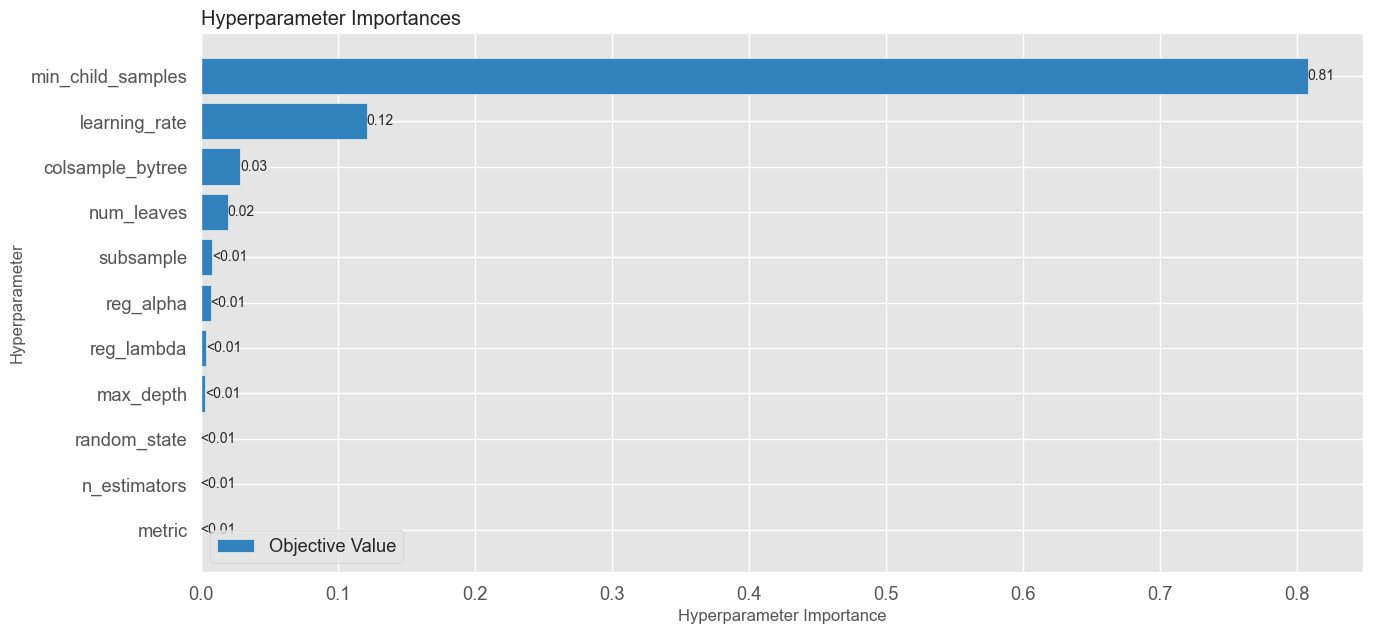

In [59]:
plot_param_importances(study);

In [60]:
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

In [61]:
best_params = training['params_path']

with open(best_params, 'w') as f:
    json.dump(study.best_params, f)

## Обучение с лучшими параметрами

In [62]:
lgb_opt = LGBMRegressor(**study.best_params)
lgb_opt.fit(
    X_train_,
    y_train_,
    eval_metric="rmse",
    eval_set=eval_set,
    verbose=False,
    early_stopping_rounds=100,
)

y_pred = lgb_opt.predict(X_test)
y_pred_exp = np.exp(y_pred)

check_overfitting(lgb_opt, X_train_, np.exp(y_train_),
                  X_test, y_test_exp, mean_absolute_error, True)

mean_absolute_error train: 7452.479
mean_absolute_error test: 66280.983
delta = 88.8 %


In [63]:
model_path = training['model_path']

# save model
joblib.dump(lgb_opt, model_path)

['../models/model_lgb.joblib']

In [64]:
# save metrics
metrics_path = training['metrics_path']

metrics = create_dict_metrics(y_test_exp, y_pred_exp, X_test)
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

In [65]:
# check
with open(metrics_path) as json_file:
    metrics = json.load(json_file)
metrics

{'MAE': 66280.983,
 'MSE': 20299780725.277,
 'RMSE': 142477.299,
 'RMSLE': 0.169,
 'R2_adjusted': 0.86,
 'MPE_%': -2.037,
 'MAPE_%': 11.749,
 'WAPE_%': 13.503}

## Кросс-валидация

In [66]:
def cross_validation(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    clf,
    params: dict,
    eval_metric: str = None,
    early_stop: bool = False,
    early_stopping_rounds: int = 100,
    num_folds: int = 5,
    random_state: int = 26,
    shuffle: bool = True,
):
    folds = KFold(n_splits=num_folds,
                  random_state=random_state, shuffle=shuffle)
    score_oof = []
    predictions_test = []

    for fold, (train_index, test_index) in enumerate(folds.split(X_train, y_train)):
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        y_val_exp = np.exp(y_val)
        model = clf(**params)

        if early_stop == True:
            if eval_metric is None:
                model.fit(
                    X_train_,
                    y_train_,
                    eval_set=[(X_val, y_val_exp)],
                    early_stopping_rounds=early_stopping_rounds,
                )
            else:
                model.fit(
                    X_train_,
                    y_train_,
                    eval_set=[(X_val, y_val_exp)],
                    eval_metric=eval_metric,
                    verbose=0,
                    early_stopping_rounds=early_stopping_rounds,
                )
        else:
            model.fit(X_train_, y_train_)

        y_pred_val = model.predict(X_val)
        y_pred_val_exp = np.exp(y_pred_val)
        y_pred = model.predict(X_test)
        y_pred_exp = np.exp(y_pred)

        print(
            "Fold:", fold +
            1, "MAE SCORE %.3f" % mean_absolute_error(
                y_val_exp, y_pred_val_exp)
        )
        print("---")

        # oof list
        score_oof.append(mean_absolute_error(y_val_exp, y_pred_val_exp))
        # holdout list
        predictions_test.append(y_pred_exp)

    return score_oof, predictions_test

In [68]:
score_oof, predictions_test = cross_validation(
    X_train,
    y_train,
    X_test,
    y_test_exp,
    num_folds=5,
    early_stop=True,
    eval_metric="rmse",
    early_stopping_rounds=50,
    clf=LGBMRegressor,
    params=study.best_params,
)

Fold: 1 MAE SCORE 70660.868
---
Fold: 2 MAE SCORE 63930.980
---
Fold: 3 MAE SCORE 62244.888
---
Fold: 4 MAE SCORE 66179.226
---
Fold: 5 MAE SCORE 67832.318
---


In [69]:
test_pred = np.mean(predictions_test, axis=0)
oof = np.mean(score_oof)
hold = mean_absolute_error(y_test_exp, test_pred)

print("MAE mean OOF: %.3f, std: %.3f" % (oof, np.std(score_oof)))
print("MAE HOLDOUT: %.3f" % hold)

MAE mean OOF: 66169.656, std: 2944.520
MAE HOLDOUT: 66446.446


In [70]:
overfit = round(np.abs((oof-hold)/hold)*100, 2)

In [71]:
print(f'Переобучение : {overfit} %')

Переобучение : 0.42 %
